<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Start-to-Finish Example: $\text{GiRaFFE_HO}$ 1D tests

### Author: Patrick Nelson

### Adapted from [Start-to-Finish Example: Head-On Black Hole Collision](../Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide.ipynb)

## This module implements a basic GRFFE code to evolve one-dimensional GRFFE waves.

### NRPy+ Source Code for this module: 
* [GiRaFFEfood_NRPy/GiRaFFEfood_NRPy_Exact_Wald.py](../../edit/in_progress/GiRaFFEfood_NRPy/GiRaFFEfood_NRPy_Exact_Wald.py) [\[**tutorial**\]](Tutorial-GiRaFFEfood_NRPy_Exact_Wald.ipynb) Generates Exact Wald initial data
* [GiRaFFEfood_NRPy/GiRaFFEfood_NRPy_Aligned_Rotator.py](../../edit/in_progress/GiRaFFEfood_NRPy/GiRaFFEfood_NRPy_Aligned_Rotator.py) [\[**tutorial**\]](Tutorial-GiRaFFEfood_NRPy_Aligned_Rotator.ipynb) Generates Aligned Rotator initial data
* [GiRaFFEfood_NRPy/GiRaFFEfood_NRPy_1D_tests.py](../../edit/in_progress/GiRaFFEfood_NRPy/GiRaFFEfood_NRPy_1D_tests.py) [\[**tutorial**\]](Tutorial-GiRaFFEfood_NRPy_1D_tests.ipynb) Generates Alfv&eacute;n Wave initial data.
* [GiRaFFE_NRPy/Afield_flux.py](../../edit/in_progress/GiRaFFE_NRPy/Afield_flux.py) [\[**tutorial**\]](Tutorial-GiRaFFE_NRPy-Afield_flux.ipynb) Generates the expressions to find the flux term of the induction equation.
* [GiRaFFE_NRPy/GiRaFFE_NRPy_A2B.py](../../edit/in_progress/GiRaFFE_NRPy/GiRaFFE_NRPy_A2B.py) [\[**tutorial**\]](Tutorial-GiRaFFE_NRPy-Afield_flux.ipynb) Generates the driver to compute the magnetic field from the vector potential/
* [GiRaFFE_NRPy/GiRaFFE_NRPy_BCs.py](../../edit/in_progress/GiRaFFE_NRPy/GiRaFFE_NRPy_BCs.py) [\[**tutorial**\]](Tutorial-GiRaFFE_NRPy-BCs.ipynb) Generates the code to apply boundary conditions to the vector potential, scalar potential, and three-velocity.
* [GiRaFFE_NRPy/GiRaFFE_NRPy_C2P_P2C.py](../../edit/in_progress/GiRaFFE_NRPy/GiRaFFE_NRPy_C2P_P2C.py) [\[**tutorial**\]](Tutorial-GiRaFFE_NRPy-C2P_P2C.ipynb) Generates the conservative-to-primitive and primitive-to-conservative solvers.
* [GiRaFFE_NRPy/GiRaFFE_NRPy_Metric_Face_Values.py](../../edit/in_progress/GiRaFFE_NRPy/GiRaFFE_NRPy_Metric_Face_Values.py) [\[**tutorial**\]](Tutorial-GiRaFFE_NRPy-Metric_Face_Values.ipynb) Generates code to interpolate metric gridfunctions to cell faces.
* [GiRaFFE_NRPy/GiRaFFE_NRPy_PPM.py](../../edit/in_progress/GiRaFFE_NRPy/GiRaFFE_NRPy_PPM.py) [\[**tutorial**\]](Tutorial-GiRaFFE_NRPy-PPM.ipynb) Genearates code to reconstruct primitive variables on cell faces.
* [GiRaFFE_NRPy/Stilde_flux.py](../../edit/in_progress/GiRaFFE_NRPy/Stilde_flux.py) [\[**tutorial**\]](Tutorial-GiRaFFE_NRPy-Stilde_flux.ipynb) Generates the expressions to find the flux term of the Poynting flux evolution equation.
* [../GRFFE/equations.py](../../edit/GRFFE/equations.py) [\[**tutorial**\]](../Tutorial-GRFFE_Equations-Cartesian.ipynb) Generates code necessary to compute the source terms.
* [../GRHD/equations.py](../../edit/GRHD/equations.py) [\[**tutorial**\]](../Tutorial-GRHD_Equations-Cartesian.ipynb) Generates code necessary to compute the source terms.

Here we use NRPy+ to generate the C source code necessary to set up initial data for a model neutron star (see [the original GiRaFFE paper](https://arxiv.org/pdf/1704.00599.pdf)). Then we use it to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on the [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4).

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. (**Step 2** below) <font color='green'>Set gridfunction values to initial data (**[documented in previous module](Tutorial-GiRaFFEfood_HO_1D_tests.ipynb)**).</font>
1. <font color='green'>Evolve the initial data forward in time using RK4 time integration.</font> At each RK4 substep, do the following:
    1. (**Step 3A** below) <font color='green'>Evaluate GRFFE RHS expressions.</font>
    1. (**Step 4** below) Apply singular, curvilinear coordinate boundary conditions [*a la* the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658)
1. (**Step 3B** below) At the end of each iteration in time, output the <font color='green'>FFE variables</font>. (This is in Step 3B, because Step 4 requires that *all* gridfunctions be defined.)
1. Repeat above steps at two numerical resolutions to confirm convergence to the expected value.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#initializenrpy): Set core NRPy+ parameters for numerical grids
1. [Step 2](#grffe): Output C code for GRFFE evolution
1. [Step 3](#gf_id): Import `GiRaFFEfood_NRPy` initial data modules
1. [Step 4](#cparams): Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h`
1. [Step 5](#mainc): `GiRaFFE_NRPy_standalone.c`: The Main C Code
1. [Step 6](#compileexec): Compile generated C codes & perform the black hole collision calculation


<a id='setup'></a>

# Step 1: Set up core functions and parameters for solving  GRFFE equations \[Back to [top](#toc)\]
$$\label{setup}$$


In [1]:
import shutil, os, sys           # Standard Python modules for multiplatform OS-level functions
# First, we'll add the parent directory to the list of directories Python will check for modules.
nrpy_dir_path = os.path.join("..")
if nrpy_dir_path not in sys.path:
    sys.path.append(nrpy_dir_path)

# Step P1: Import needed NRPy+ core modules:
from outputC import *            # NRPy+: Core C code output module
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import grid as gri               # NRPy+: Functions having to do with numerical grids
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface

# Step P2: Create C code output directory:
Ccodesdir = os.path.join("GiRaFFE_standalone_Ccodes/")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
# !rm -r ScalarWaveCurvilinear_Playground_Ccodes
shutil.rmtree(Ccodesdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesdir)

# Step P3: Create executable output directory:
outdir = os.path.join(Ccodesdir,"output/")
cmd.mkdir(Ccodesdir)
cmd.mkdir(outdir)

# Step P5: Set timestepping algorithm (we adopt the Method of Lines)
REAL      = "double"    # Best to use double here.
default_CFL_FACTOR= 0.5 # (GETS OVERWRITTEN WHEN EXECUTED.) In pure axisymmetry (symmetry_axes = 2 below) 1.0 works fine. Otherwise 0.5 or lower.

# Step P6: Set the finite differencing order to 2.
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER",2)

# Step 3: Set the spatial dimension parameter
#         to 3, and then read the parameter as DIM.
par.set_parval_from_str("grid::DIM",3)
DIM = par.parval_from_str("grid::DIM")

thismodule = "Start_to_Finish-GiRaFFE_NRPy-1D_tests"
TINYDOUBLE = par.Cparameters("REAL", thismodule, "TINYDOUBLE", 1e-100)

import GiRaFFE_NRPy.GiRaFFE_NRPy_Main_Driver as md
par.set_paramsvals_value("GiRaFFE_NRPy.GiRaFFE_NRPy_C2P_P2C::enforce_current_sheet_prescription = False")

<a id='grffe'></a>

# Step 2: Output C code for GRFFE evolution \[Back to [top](#toc)\]
$$\label{grffe}$$

We will first write the the C codes needed for GRFFE evolution. We have already written a module to generate all these codes in order and call the functions in the appropriate order, so we will import that here. We will take the slightly unusual step of doing this before we generate the initial data functions because the main driver module will register all the gridfunctions we need. We will also include the file early on, because it will generate functions that, in addition to their normal spot in the MoL timestepping, will need to be called during the initial data step to make sure all the variables are appropriately filled in. 

In [2]:
md.GiRaFFE_NRPy_Main_Driver_generate_all(Ccodesdir)

RK_method = "Euler"

# Step 3: Generate Runge-Kutta-based (RK-based) timestepping code. 
#       As described above the Table of Contents, this is a 3-step process:
#       3.A: Evaluate RHSs (RHS_string)
#       3.B: Apply boundary conditions (post_RHS_string, pt 1)
import MoLtimestepping.C_Code_Generation as MoL
from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
RK_order  = Butcher_dict[RK_method][1]
cmd.mkdir(os.path.join(Ccodesdir,"MoLtimestepping/"))
MoL.MoL_C_Code_Generation(RK_method, 
    RHS_string      = """
GiRaFFE_NRPy_RHSs(&params,auxevol_gfs,RK_INPUT_GFS,RK_OUTPUT_GFS);""",
    post_RHS_string = """
GiRaFFE_NRPy_post_step(&params,xx,auxevol_gfs,RK_OUTPUT_GFS);\n""",
    outdir = os.path.join(Ccodesdir,"MoLtimestepping/"))


Output C function calculate_parentheticals_for_RHSs() to file GiRaFFE_standalone_Ccodes/RHSs/calculate_parentheticals_for_RHSs.h
Output C function calculate_StildeD0_source_term() to file GiRaFFE_standalone_Ccodes/RHSs/calculate_StildeD0_source_term.h
Output C function calculate_StildeD1_source_term() to file GiRaFFE_standalone_Ccodes/RHSs/calculate_StildeD1_source_term.h
Output C function calculate_StildeD2_source_term() to file GiRaFFE_standalone_Ccodes/RHSs/calculate_StildeD2_source_term.h
Output C function calculate_E_field_D0_right() to file GiRaFFE_standalone_Ccodes/RHSs/calculate_E_field_D0_right.h
Output C function calculate_E_field_D0_left() to file GiRaFFE_standalone_Ccodes/RHSs/calculate_E_field_D0_left.h
Output C function calculate_E_field_D1_right() to file GiRaFFE_standalone_Ccodes/RHSs/calculate_E_field_D1_right.h
Output C function calculate_E_field_D1_left() to file GiRaFFE_standalone_Ccodes/RHSs/calculate_E_field_D1_left.h
Output C function calculate_E_field_D2_right()

<a id='gf_id'></a>

# Step 3: Import `GiRaFFEfood_NRPy` initial data modules \[Back to [top](#toc)\]
$$\label{gf_id}$$

With the preliminaries out of the way, we will write the C functions to set up initial data. There are two categories of initial data that must be set: the spacetime metric variables, and the GRFFE plasma variables. We will set up the spacetime first.

In [3]:
# There are several initial data routines we need to test. We'll control which one we use with a string option
initial_data = "AlfvenWave" # Valid options: "ExactWald", "AlignedRotator", "AlfvenWave"
spacetime = "flat" # Valid options: "ShiftedKerrSchild", "flat"

if spacetime == "ShiftedKerrSchild":
    # Exact Wald is more complicated. We'll need the Shifted Kerr Schild metric in Cartesian coordinates.
    import BSSN.ShiftedKerrSchild as sks
    sks.ShiftedKerrSchild(True)
    import reference_metric as rfm
    par.set_parval_from_str("reference_metric::CoordSystem","Cartesian")
    rfm.reference_metric()
    # Use the Jacobian matrix to transform the vectors to Cartesian coordinates.
    drrefmetric__dx_0UDmatrix = sp.Matrix([[sp.diff(rfm.xxSph[0],rfm.xx[0]), sp.diff(rfm.xxSph[0],rfm.xx[1]), sp.diff(rfm.xxSph[0],rfm.xx[2])],
                                           [sp.diff(rfm.xxSph[1],rfm.xx[0]), sp.diff(rfm.xxSph[1],rfm.xx[1]), sp.diff(rfm.xxSph[1],rfm.xx[2])],
                                           [sp.diff(rfm.xxSph[2],rfm.xx[0]), sp.diff(rfm.xxSph[2],rfm.xx[1]), sp.diff(rfm.xxSph[2],rfm.xx[2])]])
    dx__drrefmetric_0UDmatrix = drrefmetric__dx_0UDmatrix.inv()
    gammaDD = ixp.zerorank2()
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    gammaDD[i][j] += drrefmetric__dx_0UDmatrix[(k,i)]*drrefmetric__dx_0UDmatrix[(l,j)]*sks.gammaSphDD[k][l].subs(sks.r,rfm.xxSph[0]).subs(sks.th,rfm.xxSph[1])
    betaU = ixp.zerorank1()
    for i in range(3):
        for j in range(3):
            betaU[i] += dx__drrefmetric_0UDmatrix[(i,j)]*sks.betaSphU[j].subs(sks.r,rfm.xxSph[0]).subs(sks.th,rfm.xxSph[1])
    alpha = sks.alphaSph.subs(sks.r,rfm.xxSph[0]).subs(sks.th,rfm.xxSph[1])

    # Description and options for this initial data
    desc = "Generate a spinning black hole with Shifted Kerr Schild metric."
    loopopts_id ="AllPoints,Read_xxs"
    
elif spacetime == "flat":
    gammaDD = ixp.zerorank2(DIM=3)
    for i in range(3):
        for j in range(3):
            if i==j:
                gammaDD[i][j] = sp.sympify(1) # else: leave as zero
    betaU = ixp.zerorank1() # All should be 0
    alpha = sp.sympify(1)
    
    # Description and options for this initial data
    desc = "Generate a flat spacetime metric."
    loopopts_id ="AllPoints" # we don't need to read coordinates for flat spacetime.


name = "set_initial_spacetime_metric_data"
values_to_print = [\
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD00"),rhs=gammaDD[0][0]),\
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD01"),rhs=gammaDD[0][1]),\
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD02"),rhs=gammaDD[0][2]),\
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD11"),rhs=gammaDD[1][1]),\
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD12"),rhs=gammaDD[1][2]),\
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD22"),rhs=gammaDD[2][2]),\
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","betaU0"),rhs=betaU[0]),\
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","betaU1"),rhs=betaU[1]),\
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","betaU2"),rhs=betaU[2]),\
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","alpha"),rhs=alpha),\
                  ]

outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
    params   ="const paramstruct *params,REAL *xx[3],REAL *auxevol_gfs",
    body     = fin.FD_outputC("returnstring",values_to_print,params="outCverbose=False").replace("IDX4","IDX4S"),
    loopopts = loopopts_id)


Output C function set_initial_spacetime_metric_data() to file GiRaFFE_standalone_Ccodes/set_initial_spacetime_metric_data.h


Now, we will write out the initial data function for the GRFFE variables.

In [4]:
if initial_data=="AlfvenWave":
    import GiRaFFEfood_NRPy.GiRaFFEfood_NRPy_1D_tests as gid
    gid.GiRaFFEfood_NRPy_1D_tests()
    desc = "Generate Alfven wave 1D initial test data for GiRaFFEfood_NRPy."
elif initial_data=="AlignedRotator":
    import GiRaFFEfood_NRPy.GiRaFFEfood_NRPy_Aligned_Rotator as gid
    gid.GiRaFFEfood_NRPy_Aligned_Rotator()
    desc = "Generate aligned rotator initial test data for GiRaFFEfood_NRPy."
elif initial_data=="ExactWald":
    import GiRaFFEfood_NRPy.GiRaFFEfood_NRPy_Exact_Wald as gid
    M,r0 = sp.symbols("M r0")
    gid.GiRaFFEfood_NRPy_Exact_Wald(gammaDD,M,r0)
    desc = "Generate exact Wald initial test data for GiRaFFEfood_NRPy."
else:
    print("Unsupported Initial Data string "+initial_data+"! Supported ID: AlfvenWave, AlignedRotator, or ExactWald")

name = "initial_data"

values_to_print = [\
                   lhrh(lhs=gri.gfaccess("out_gfs","AD0"),rhs=gid.AD[0]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","AD1"),rhs=gid.AD[1]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","AD2"),rhs=gid.AD[2]),\
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","ValenciavU0"),rhs=gid.ValenciavU[0]),\
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","ValenciavU1"),rhs=gid.ValenciavU[1]),\
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","ValenciavU2"),rhs=gid.ValenciavU[2]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","psi6Phi"),rhs=sp.sympify(0))\
                  ]

outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
    params   ="const paramstruct *params,REAL *xx[3],REAL *auxevol_gfs,REAL *out_gfs",
    body     = fin.FD_outputC("returnstring",values_to_print,params="outCverbose=False").replace("IDX4","IDX4S"),
    loopopts ="AllPoints,Read_xxs")


Output C function initial_data() to file GiRaFFE_standalone_Ccodes/initial_data.h


<a id='cparams'></a>

# Step 4: Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h` \[Back to [top](#toc)\]
$$\label{cparams}$$

Based on declared NRPy+ Cparameters, first we generate `declare_Cparameters_struct.h`, `set_Cparameters_default.h`, and `set_Cparameters[-SIMD].h`.

Then we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above

In [5]:
# Step 3.e: Output C codes needed for declaring and setting Cparameters; also set free_parameters.h
# Step 3.e.i: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

# Step 3.e.ii: Set free_parameters.h
with open(os.path.join(Ccodesdir,"free_parameters.h"),"w") as file:
    file.write("""// Override parameter defaults with values based on command line arguments and NGHOSTS.
params.Nxx0 = atoi(argv[1]);
params.Nxx1 = atoi(argv[2]);
params.Nxx2 = atoi(argv[3]);
params.Nxx_plus_2NGHOSTS0 = params.Nxx0 + 2*NGHOSTS;
params.Nxx_plus_2NGHOSTS1 = params.Nxx1 + 2*NGHOSTS;
params.Nxx_plus_2NGHOSTS2 = params.Nxx2 + 2*NGHOSTS;
// Step 0d: Set up space and time coordinates
// Step 0d.i: Declare \Delta x^i=dxx{0,1,2} and invdxx{0,1,2}, as well as xxmin[3] and xxmax[3]:
const REAL xxmin[3] = {-4.0,-0.1,-0.1};
const REAL xxmax[3] = { 4.0, 0.1, 0.1};
//const REAL xxmin[3] = {-1.0,-1.0,-1.0};
//const REAL xxmax[3] = { 1.0, 1.0, 1.0};

params.dxx0 = (xxmax[0] - xxmin[0]) / ((REAL)params.Nxx0);
params.dxx1 = (xxmax[1] - xxmin[1]) / ((REAL)params.Nxx1);
params.dxx2 = (xxmax[2] - xxmin[2]) / ((REAL)params.Nxx2);
//printf("dxx0,dxx1,dxx2 = %.5e,%.5e,%.5e\\n",params.dxx0,params.dxx1,params.dxx2);
params.invdx0 = 1.0 / params.dxx0;
params.invdx1 = 1.0 / params.dxx1;
params.invdx2 = 1.0 / params.dxx2;

const int poison_grids = 0;
""")
if initial_data=="ExactWald":
    with open(os.path.join(out_dir,"free_parameters.h"),"a") as file:
        file.write("""params.r0 = 0.4;
params.a = 0.0;
""")


<a id='bc_functs'></a>

# Step 4: Set up boundary condition functions for chosen singular, curvilinear coordinate system \[Back to [top](#toc)\]
$$\label{bc_functs}$$

Next apply singular, curvilinear coordinate boundary conditions [as documented in the corresponding NRPy+ tutorial notebook](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb)

...But, for the moment, we're actually just using this because it writes the file `gridfunction_defines.h`.

In [6]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
cbcs.Set_up_CurviBoundaryConditions(os.path.join(Ccodesdir,"boundary_conditions/"),Cparamspath=os.path.join("../"),enable_copy_of_static_Ccodes=False)

Wrote to file "GiRaFFE_standalone_Ccodes/boundary_conditions/parity_conditions_symbolic_dot_products.h"
Evolved gridfunction "AD0" has parity type 1.
Evolved gridfunction "AD1" has parity type 2.
Evolved gridfunction "AD2" has parity type 3.
Evolved gridfunction "StildeD0" has parity type 1.
Evolved gridfunction "StildeD1" has parity type 2.
Evolved gridfunction "StildeD2" has parity type 3.
Evolved gridfunction "psi6Phi" has parity type 0.
AuxEvol gridfunction "AevolParen" has parity type 0.
AuxEvol gridfunction "BU0" has parity type 1.
AuxEvol gridfunction "BU1" has parity type 2.
AuxEvol gridfunction "BU2" has parity type 3.
AuxEvol gridfunction "B_lU0" has parity type 1.
AuxEvol gridfunction "B_lU1" has parity type 2.
AuxEvol gridfunction "B_lU2" has parity type 3.
AuxEvol gridfunction "B_rU0" has parity type 1.
AuxEvol gridfunction "B_rU1" has parity type 2.
AuxEvol gridfunction "B_rU2" has parity type 3.
AuxEvol gridfunction "PhievolParenU0" has parity type 1.
AuxEvol gridfunctio

<a id='mainc'></a>

# Step 5: `GiRaFFE_NRPy_standalone.c`: The Main C Code \[Back to [top](#toc)\]
$$\label{mainc}$$

In [7]:
# Part P0: Define REAL, set the number of ghost cells NGHOSTS (from NRPy+'s FD_CENTDERIVS_ORDER),
#          and set the CFL_FACTOR (which can be overwritten at the command line)

with open(os.path.join(Ccodesdir,"GiRaFFE_NRPy_REAL__NGHOSTS__CFL_FACTOR.h"), "w") as file:
    file.write("""
// Part P0.a: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
#define NGHOSTS """+str(3)+"""
#define NGHOSTS_A2B """+str(1)+"""
// Part P0.b: Set the numerical precision (REAL) to double, ensuring all floating point
//            numbers are stored to at least ~16 significant digits
#define REAL """+REAL+"""
// Part P0.c: Set the CFL Factor. Can be overwritten at command line.
REAL CFL_FACTOR = """+str(default_CFL_FACTOR)+";")

In [8]:
%%writefile $Ccodesdir/GiRaFFE_NRPy_standalone.c
// Step P0: Define REAL and NGHOSTS; and declare CFL_FACTOR. This header is generated in NRPy+.
#include "GiRaFFE_NRPy_REAL__NGHOSTS__CFL_FACTOR.h"

#include "declare_Cparameters_struct.h"

const int NSKIP_1D_OUTPUT = 1;

// Step P1: Import needed header files
#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#include "time.h"
#include "stdint.h" // Needed for Windows GCC 6.x compatibility
#ifndef M_PI
#define M_PI 3.141592653589793238462643383279502884L
#endif
#ifndef M_SQRT1_2
#define M_SQRT1_2 0.707106781186547524400844362104849039L
#endif

// Step P2: Declare the IDX4S(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i" 
//           (all other indices held to a fixed value) are consecutive in memory, where 
//           consecutive values of "j" (fixing all other indices) are separated by 
//           Nxx_plus_2NGHOSTS0 elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1 in memory, etc.
#define IDX4S(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) + Nxx_plus_2NGHOSTS2 * (g) ) ) )
#define IDX4ptS(g,idx) ( (idx) + (Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2) * (g) )
#define IDX3S(i,j,k) ( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) ) ) )
#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)
#define LOOP_ALL_GFS_GPS(ii) _Pragma("omp parallel for") \
  for(int (ii)=0;(ii)<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;(ii)++)

// Step P3: Set gridfunction macros
#include "boundary_conditions/gridfunction_defines.h"

// Step P4: Include the RHS, BC, and primitive recovery functions
#include "GiRaFFE_NRPy_Main_Driver.h"

// Step P5: Include the initial data functions
#include "set_initial_spacetime_metric_data.h"
#include "initial_data.h"
// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up scalar wave initial data
// Step 2: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
//         applying quadratic extrapolation outer boundary conditions.
// Step 3: Output relative error between numerical and exact solution.
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {
    paramstruct params;
#include "set_Cparameters_default.h"
    // Step 0a: Read command-line input, error out if nonconformant
    if(argc != 4 || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < NGHOSTS) {
      printf("Error: Expected three command-line arguments: ./GiRaFFE_NRPy_standalone [Nx] [Ny] [Nz],\n");
      printf("where Nx is the number of grid points in the x direction, and so forth.\n");
      printf("Nx,Ny,Nz MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
      exit(1);
    }
    // Step 0c: Set free parameters, overwriting Cparameters defaults 
    //          by hand or with command-line input, as desired.
#include "free_parameters.h"
#include "set_Cparameters-nopointer.h"

    //          ... and then set up the numerical grid structure in time:
    const REAL t_final = 0.1/32; 
    const REAL CFL_FACTOR = 0.5; // Set the CFL Factor

    // Step 0c: Allocate memory for gridfunctions
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;
    // Step 0k: Allocate memory for gridfunctions
#include "MoLtimestepping/RK_Allocate_Memory.h"
    REAL *restrict auxevol_gfs = (REAL *)malloc(sizeof(REAL) * NUM_AUXEVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *evol_gfs_exact = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *auxevol_gfs_exact  = (REAL *)malloc(sizeof(REAL) * NUM_AUXEVOL_GFS * Nxx_plus_2NGHOSTS_tot);

    // For debugging, it can be useful to set everything to NaN initially. 
    if(poison_grids) {
        for(int ii=0;ii<NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot;ii++) {
            y_n_gfs[ii] = 1.0/0.0;
            y_nplus1_running_total_gfs[ii] = 1.0/0.0;
            //k_odd_gfs[ii] = 1.0/0.0;
            //k_even_gfs[ii] = 1.0/0.0;
            diagnostic_output_gfs[ii] = 1.0/0.0;
            evol_gfs_exact[ii] = 1.0/0.0;
        }
        for(int ii=0;ii<NUM_AUXEVOL_GFS * Nxx_plus_2NGHOSTS_tot;ii++) {
            auxevol_gfs[ii] = 1.0/0.0;
            auxevol_gfs_exact[ii] = 1.0/0.0;
        }
    }
    
    // Step 0d: Set up coordinates: Set dx, and then dt based on dx_min and CFL condition
    // This is probably already defined above, but just in case...
    #ifndef MIN
    #define MIN(A, B) ( ((A) < (B)) ? (A) : (B) )
    #endif
    REAL dt = CFL_FACTOR * MIN(dxx0,MIN(dxx1,dxx2)); // CFL condition
    int Nt = (int)(t_final / dt + 0.5); // The number of points in time.
                                        //Add 0.5 to account for C rounding down integers.

    // Step 0e: Set up cell-centered Cartesian coordinate grids
    REAL *xx[3];
    xx[0] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS0);
    xx[1] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS1);
    xx[2] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS2);
    for(int j=0;j<Nxx_plus_2NGHOSTS0;j++) xx[0][j] = xxmin[0] + (j-NGHOSTS+1)*dxx0;
    for(int j=0;j<Nxx_plus_2NGHOSTS1;j++) xx[1][j] = xxmin[1] + (j-NGHOSTS+1)*dxx1;
    for(int j=0;j<Nxx_plus_2NGHOSTS2;j++) xx[2][j] = xxmin[2] + (j-NGHOSTS+1)*dxx2;

    // Step 1: Set up initial data to be exact solution at time=0:
    REAL time = 0.0; 
    set_initial_spacetime_metric_data(&params,xx,auxevol_gfs);
    initial_data(&params,xx,auxevol_gfs,y_n_gfs);
    // Fill in  the remaining quantities
    driver_A_to_B(&params,y_n_gfs,auxevol_gfs);
    GiRaFFE_NRPy_prims_to_cons(&params,auxevol_gfs,y_n_gfs);
    // Extra stack, useful for debugging:
    GiRaFFE_NRPy_cons_to_prims(&params,xx,auxevol_gfs,y_n_gfs);
    //GiRaFFE_NRPy_prims_to_cons(&params,auxevol_gfs,y_n_gfs);
    //GiRaFFE_NRPy_cons_to_prims(&params,xx,auxevol_gfs,y_n_gfs);
    //GiRaFFE_NRPy_prims_to_cons(&params,auxevol_gfs,y_n_gfs);
    //GiRaFFE_NRPy_cons_to_prims(&params,xx,auxevol_gfs,y_n_gfs);
    
    for(int n=0;n<=Nt;n++) { // Main loop to progress forward in time.
        // Step 1a: Set current time to correct value & compute exact solution
        time = ((REAL)n)*dt;

        /* Step 2: Validation: Output relative error between numerical and exact solution, */
        if((n)%NSKIP_1D_OUTPUT ==0) {
            // Step 2c: Output relative error between exact & numerical at center of grid.
            //const int i0mid=Nxx_plus_2NGHOSTS0/2;
            const int i1mid=Nxx_plus_2NGHOSTS1/2;
            const int i2mid=Nxx_plus_2NGHOSTS2/2;
            char filename[100];
            sprintf(filename,"out%d-%08d.txt",Nxx0,n);
            FILE *out2D = fopen(filename, "w");
            for(int i0=0;i0<Nxx_plus_2NGHOSTS0;i0++) {
                const int idx = IDX3S(i0,i1mid,i2mid);
                fprintf(out2D,"%.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e\n",
                        xx[0][i0],
                        auxevol_gfs[IDX4ptS(BU0GF,idx)],auxevol_gfs[IDX4ptS(BU1GF,idx)],auxevol_gfs[IDX4ptS(BU2GF,idx)],
                        y_n_gfs[IDX4ptS(AD0GF,idx)],y_n_gfs[IDX4ptS(AD1GF,idx)],y_n_gfs[IDX4ptS(AD2GF,idx)],
                        y_n_gfs[IDX4ptS(STILDED0GF,idx)],y_n_gfs[IDX4ptS(STILDED1GF,idx)],y_n_gfs[IDX4ptS(STILDED2GF,idx)],
                        auxevol_gfs[IDX4ptS(VALENCIAVU0GF,idx)],auxevol_gfs[IDX4ptS(VALENCIAVU1GF,idx)],auxevol_gfs[IDX4ptS(VALENCIAVU2GF,idx)]);
            }
            fclose(out2D);
            // For convergence testing, we'll shift the grid x -> x-1 and output initial data again, giving the exact solution.
            LOOP_REGION(0,Nxx_plus_2NGHOSTS0,0,1,0,1) {
                xx[0][i0] += -mu_AW*time;
            }
            set_initial_spacetime_metric_data(&params,xx,auxevol_gfs_exact);
            initial_data(&params,xx,auxevol_gfs_exact,evol_gfs_exact);
            // Fill in  the remaining quantities
            driver_A_to_B(&params,evol_gfs_exact,auxevol_gfs_exact);
            GiRaFFE_NRPy_prims_to_cons(&params,auxevol_gfs_exact,evol_gfs_exact);
            // And now, we'll set the grid back to rights.
            LOOP_REGION(0,Nxx_plus_2NGHOSTS0,0,1,0,1) {
                xx[0][i0] -= -mu_AW*time;
            }
            sprintf(filename,"out%d-%08d_exact.txt",Nxx0,n);
            FILE *out2D_exact = fopen(filename, "w");
            for(int i0=0;i0<Nxx_plus_2NGHOSTS0;i0++) {
                const int idx = IDX3S(i0,i1mid,i2mid);
                fprintf(out2D_exact,"%.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e\n",
                        xx[0][i0],
                        auxevol_gfs_exact[IDX4ptS(BU0GF,idx)],auxevol_gfs_exact[IDX4ptS(BU1GF,idx)],auxevol_gfs_exact[IDX4ptS(BU2GF,idx)],
                        evol_gfs_exact[IDX4ptS(AD0GF,idx)],evol_gfs_exact[IDX4ptS(AD1GF,idx)],evol_gfs_exact[IDX4ptS(AD2GF,idx)],
                        evol_gfs_exact[IDX4ptS(STILDED0GF,idx)],evol_gfs_exact[IDX4ptS(STILDED1GF,idx)],evol_gfs_exact[IDX4ptS(STILDED2GF,idx)],
                        auxevol_gfs_exact[IDX4ptS(VALENCIAVU0GF,idx)],auxevol_gfs_exact[IDX4ptS(VALENCIAVU1GF,idx)],auxevol_gfs_exact[IDX4ptS(VALENCIAVU2GF,idx)]);
            }
            fclose(out2D_exact);

        }
                            
        // Step 3: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
        //         applying quadratic extrapolation outer boundary conditions.
        // Step 3.b: Step forward one timestep (t -> t+dt) in time using 
        //           chosen RK-like MoL timestepping algorithm
#include "MoLtimestepping/RK_MoL.h"
    } // End main loop to progress forward in time.

    // Step 4: Free all allocated memory
#include "MoLtimestepping/RK_Free_Memory.h"
    free(auxevol_gfs);
    free(auxevol_gfs_exact);
    free(evol_gfs_exact);
    for(int i=0;i<3;i++) free(xx[i]);
    return 0;
}

Writing GiRaFFE_standalone_Ccodes//GiRaFFE_NRPy_standalone.c


In [9]:
cmd.C_compile(os.path.join(Ccodesdir,"GiRaFFE_NRPy_standalone.c"),
              os.path.join(Ccodesdir,"output","GiRaFFE_NRPy_standalone"),compile_mode="safe")
# !gcc -g -O2 -fopenmp GiRaFFE_standalone_Ccodes/GiRaFFE_NRPy_standalone.c -o GiRaFFE_NRPy_standalone -lm

# Change to output directory
os.chdir(outdir)
# Clean up existing output files
cmd.delete_existing_files("out*.txt")
cmd.delete_existing_files("out*.png")
# cmd.Execute(os.path.join(Ccodesdir,"output","GiRaFFE_NRPy_standalone"), "640 16 16", os.path.join(outdir,"out640.txt"))
# cmd.Execute(os.path.join(Ccodesdir,"output","GiRaFFE_NRPy_standalone"), "1280 32 32", os.path.join(outdir,"out1280.txt"))
# !OMP_NUM_THREADS=1 valgrind --track-origins=yes -v ./GiRaFFE_NRPy_standalone 1280 32 32
!./GiRaFFE_NRPy_standalone 1280 32 32
# Return to root directory
os.chdir(os.path.join("../../"))

Compiling executable...
Executing `gcc -O2 -g -fopenmp GiRaFFE_standalone_Ccodes/GiRaFFE_NRPy_standalone.c -o GiRaFFE_standalone_Ccodes/output/GiRaFFE_NRPy_standalone -lm`...
Finished executing in 2.4158077239990234 seconds.
Finished compilation.


Now, we will load the data generated by the simulation and plot it in order to test for convergence. 

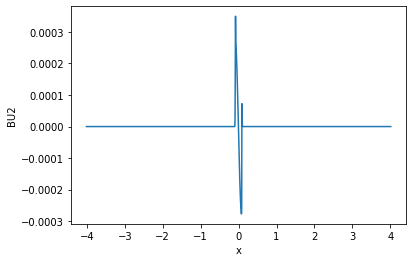

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Data_numer = np.loadtxt(os.path.join("GiRaFFE_standalone_Ccodes","output","out1280-00000032.txt"))
# # Data_num_2 = np.loadtxt("out2560-00000600_numer.txt")
# Data_exact = np.loadtxt(os.path.join("GiRaFFE_standalone_Ccodes","output","out1280-00000032_exact.txt"))
# # Data_exa_2 = np.loadtxt("out2560-00000600_exact.txt")

# predicted_order = 4.0
# column = 3
# plt.figure()
# # #plt.plot(Data_numer[:,0],Data_numer[:,column]-Data_exact[:,column])
# # #plt.plot(Data_num_2[:,0],(Data_num_2[:,column]-Data_exa_2[:,column])*(2**predicted_order),'.')
# plt.plot(Data_numer[:,0],Data_exact[:,column])
# plt.plot(Data_numer[:,0],Data_numer[:,column],'.')
# # #plt.xlim(0.0,0.15)
# # #plt.ylim(1.40,1.55)
# # #plt.ylim(-0.0005,0.0005)
# plt.xlabel("x")
# plt.ylabel("BU2")
# plt.show()

#          0   1     2     3     4     5     6     7          8          9          10            11            12
labels = ["x","BU0","BU1","BU2","AD0","AD1","AD2","StildeD0","StildeD1","StildeD2","ValenciavU0","ValenciavU1","ValenciavU2"]
old_files = ["",
             "giraffe-grmhd_primitives_bi.x.asc","giraffe-grmhd_primitives_bi.x.asc","giraffe-grmhd_primitives_bi.x.asc",
             "giraffe-em_ax.x.asc","giraffe-em_ay.x.asc","giraffe-em_az.x.asc",
             "giraffe-grmhd_conservatives.x.asc","giraffe-grmhd_conservatives.x.asc","giraffe-grmhd_conservatives.x.asc",
             "giraffe-grmhd_primitives_allbutbi.x.asc","giraffe-grmhd_primitives_allbutbi.x.asc","giraffe-grmhd_primitives_allbutbi.x.asc"]
column = 3
column_old = [0,12,13,14,12,12,12,12,13,14,12,13,14]
old_path = "/home/penelson/OldCactus/Cactus/exe/ABE-GiRaFFEfood_1D_AlfvenWave"
new_path = os.path.join("GiRaFFE_standalone_Ccodes","output")
data_old = np.loadtxt(os.path.join(old_path,old_files[column]))
data_old = data_old[1285:,:]# Select only the first timestep
data_new = np.loadtxt(os.path.join(new_path,"out1280-00000001.txt"))
data_new = data_new[0:1285,:]
plt.figure()
plt.plot(data_new[:,0],data_new[:,column]-data_old[:,column_old[column]])
# plt.plot(data_new[:,0],data_new[:,column])
# plt.plot(data_old[:,9],data_old[:,12])
# plt.xlim(-0.05,0.05)
plt.xlabel(labels[0])
plt.ylabel(labels[column])
plt.show()


This code will create an animation of the wave over time.

In [11]:
# import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from IPython.display import HTML
import matplotlib.image as mgimg

import glob
import sys
from matplotlib import animation

cmd.delete_existing_files("out1280-00*.png")
globby = glob.glob(os.path.join('GiRaFFE_standalone_Ccodes','output','out1280-00*.txt'))
file_list = []
for x in sorted(globby):
    file_list.append(x)

number_of_files = int(len(file_list)/2)

for timestep in range(number_of_files):
    fig = plt.figure()
    numer_filename = file_list[2*timestep]
    exact_filename = file_list[2*timestep+1]
    Numer = np.loadtxt(numer_filename)
    Exact = np.loadtxt(exact_filename)
    
    plt.title("Alfven Wave")
    plt.xlabel("x")
    plt.ylabel("BU2")
    plt.xlim(-0.5,0.5)
    plt.ylim(1.1,1.6)

    plt.plot(Numer[:,0],Numer[:,3],'.',label="Numerical")
    plt.plot(Exact[:,0],Exact[:,3],label="Exact")
    plt.legend()
    savefig(numer_filename+".png",dpi=150)
    plt.close(fig)
    sys.stdout.write("%c[2K" % 27)
    sys.stdout.write("Processing file "+numer_filename+"\r")
    sys.stdout.flush()

In [12]:
## VISUALIZATION ANIMATION, PART 2: Combine PNGs to generate movie ##
# https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
# https://stackoverflow.com/questions/23176161/animating-pngs-in-matplotlib-using-artistanimation
# !rm -f GiRaFFE_NRPy-1D_tests.mp4
cmd.delete_existing_files("GiRaFFE_NRPy-1D_tests.mp4")

fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

myimages = []

for i in range(number_of_files):
    img = mgimg.imread(file_list[2*i]+".png")
    imgplot = plt.imshow(img)
    myimages.append([imgplot])

ani = animation.ArtistAnimation(fig, myimages, interval=100,  repeat_delay=1000)
plt.close()
ani.save('GiRaFFE_NRPy-1D_tests.mp4', fps=5,dpi=150)

In [13]:
%%HTML
<video width="480" height="360" controls>
  <source src="GiRaFFE_NRPy-1D_tests.mp4" type="video/mp4">
</video>